# 1.Data preparations.
# A. Loading Libralies



In [1]:
#loading libralies
import os
import numpy as np
import cv2
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
!pip install efficientnet_pytorch -q
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import random
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")









2025-05-21 16:15:43.569803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747844143.767430      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747844143.823474      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have rmm-cu12 25.2.0 which is incompatible.


# B.loading image dataset files

In [2]:
# 1. Define paths
base_dir = '/kaggle/input/dataset-thyroid'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [3]:
# Step 2: Copy dataset to writable directory and standardize folder names


# Paths
readonly_base_path = "/kaggle/input/dataset-thyroid/dataset thyroid"
writable_base_path = "/kaggle/working/thyroid-dataset"

# Copy the dataset to a writable location
if not os.path.exists(writable_base_path):
    shutil.copytree(readonly_base_path, writable_base_path)

# 2. Exploring/Preprocesing The Train Image file


In [4]:
# 1. Standardize folder names
rename_map = {
    "Benign": "benign",
    "Malignant": "malignant",
    "normal thyroid": "normal"
}

for dataset_type in ["train", "test"]:
    dataset_path = os.path.join(writable_base_path, dataset_type)
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        for key, value in rename_map.items():
            if folder.lower() == key.lower() and folder != value:
                new_path = os.path.join(dataset_path, value)
                os.rename(folder_path, new_path)
                print(f"Renamed {folder_path} to {new_path}")

Renamed /kaggle/working/thyroid-dataset/train/normal thyroid to /kaggle/working/thyroid-dataset/train/normal
Renamed /kaggle/working/thyroid-dataset/train/Malignant to /kaggle/working/thyroid-dataset/train/malignant
Renamed /kaggle/working/thyroid-dataset/test/Benign to /kaggle/working/thyroid-dataset/test/benign
Renamed /kaggle/working/thyroid-dataset/test/normal thyroid to /kaggle/working/thyroid-dataset/test/normal
Renamed /kaggle/working/thyroid-dataset/test/Malignant to /kaggle/working/thyroid-dataset/test/malignant


In [5]:
# 2.Check the training dataset organization
base_path = '/kaggle/input/dataset-thyroid/dataset thyroid/train'
for root, dirs, files in os.walk(base_path):
    print(f'{root} contains {len(files)} images')


/kaggle/input/dataset-thyroid/dataset thyroid/train contains 0 images
/kaggle/input/dataset-thyroid/dataset thyroid/train/benign contains 292 images
/kaggle/input/dataset-thyroid/dataset thyroid/train/benign/Tiroides3 contains 223 images
/kaggle/input/dataset-thyroid/dataset thyroid/train/benign/Tiroides2 contains 337 images
/kaggle/input/dataset-thyroid/dataset thyroid/train/normal thyroid contains 164 images
/kaggle/input/dataset-thyroid/dataset thyroid/train/Malignant contains 292 images
/kaggle/input/dataset-thyroid/dataset thyroid/train/Malignant/Tiroides4 contains 430 images
/kaggle/input/dataset-thyroid/dataset thyroid/train/Malignant/Tiroides5 contains 192 images


In [6]:


# Define paths
source_path = '/kaggle/input/dataset-thyroid/dataset thyroid/train'
target_path = '/kaggle/working/thyroid_dataset'

# Copy the entire dataset to a writable location
if not os.path.exists(target_path):
    shutil.copytree(source_path, target_path)
    print("Dataset copied to /kaggle/working/thyroid_dataset")

# Now remove unwanted subfolders from /kaggle/working
unwanted_folders = ['benign/Tiroides3', 'benign/Tiroides2','Malignant/Tiroides4','Malignant/Tiroides5']  # These are top-level subfolders not under train/test

for folder in unwanted_folders:
    folder_path = os.path.join(target_path, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted: {folder_path}")
    else:
        print(f"Not found: {folder_path}")


Dataset copied to /kaggle/working/thyroid_dataset
Deleted: /kaggle/working/thyroid_dataset/benign/Tiroides3
Deleted: /kaggle/working/thyroid_dataset/benign/Tiroides2
Deleted: /kaggle/working/thyroid_dataset/Malignant/Tiroides4
Deleted: /kaggle/working/thyroid_dataset/Malignant/Tiroides5


In [7]:
import glob
# 4. Count Images per Class in train
from collections import Counter


classes = os.listdir(target_path)
class_counts = {cls: len(glob.glob(os.path.join(target_path, cls, '*.jpg'))) for cls in classes}
print(class_counts)


{'benign': 292, 'normal thyroid': 164, 'Malignant': 292}


In [8]:
# Step 5: Generate synthetic images using augmentation for training data
augmentations = augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomAffine(degrees=45, shear=20, scale=(0.6, 1.2)),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.4, 1.0)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
])


synthetic_target = 6000
train_path = os.path.join(writable_base_path, "train")


for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg'))]
    existing_count = len(images)
    print(f"Generating synthetic images for class '{class_name}' (existing: {existing_count})")

    i = 0
    while existing_count + i < synthetic_target:
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert('RGB')
        augmented_img = augmentations(img)
        synthetic_name = f"synthetic_{i}_{img_name}"
        augmented_img.save(os.path.join(class_path, synthetic_name))
        i += 1

    print(f"Generated {i} synthetic images for class '{class_name}'")

Generating synthetic images for class 'benign' (existing: 292)
Generated 5708 synthetic images for class 'benign'
Generating synthetic images for class 'malignant' (existing: 292)
Generated 5708 synthetic images for class 'malignant'
Generating synthetic images for class 'normal' (existing: 164)
Generated 5836 synthetic images for class 'normal'


In [9]:
# 6. Checking the number of trainging images after augmentation
print("Number of training images for each class after augmentation:")
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    print(f"{class_name}: {len(os.listdir(class_dir))}")

Number of training images for each class after augmentation:
benign: 6002
malignant: 6002
normal: 6000


In [10]:
# 7.View the number of images per class
def count_images(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            count = len([f for f in os.listdir(class_folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
            class_counts[class_name] = count
    return class_counts

print("Train set distribution:", count_images(os.path.join(writable_base_path, "train")))
print("Test set distribution:", count_images(os.path.join(writable_base_path, "test")))

Train set distribution: {'benign': 6000, 'malignant': 6000, 'normal': 6000}
Test set distribution: {'benign': 60, 'malignant': 292, 'normal': 7}


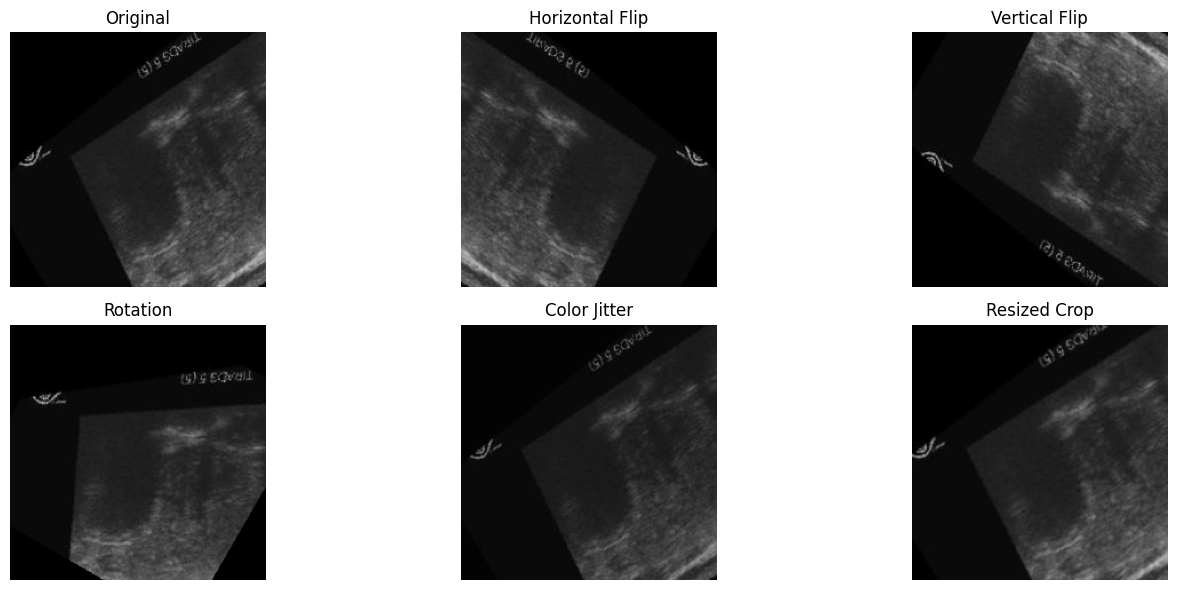

In [11]:
# 8.Visualize Each Augmentation Type
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import random
import os

# Load one sample image
sample_class_path = os.path.join(train_path, random.choice(os.listdir(train_path)))
sample_image_path = os.path.join(sample_class_path, random.choice(os.listdir(sample_class_path)))
img = Image.open(sample_image_path).convert('RGB')

# Define individual augmentations
augmentations = {
    "Original": transforms.Compose([]),
    "Horizontal Flip": transforms.Compose([transforms.RandomHorizontalFlip(p=1)]),
    "Vertical Flip": transforms.Compose([transforms.RandomVerticalFlip(p=1)]),
    "Rotation": transforms.Compose([transforms.RandomRotation(30)]),
    "Color Jitter": transforms.Compose([transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)]),
    "Resized Crop": transforms.Compose([transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0))]),
}

# Plot the images
plt.figure(figsize=(15, 6))
for i, (name, aug) in enumerate(augmentations.items()):
    augmented = aug(img)
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented)
    plt.title(name)
    plt.axis('off')

plt.tight_layout()
plt.show()

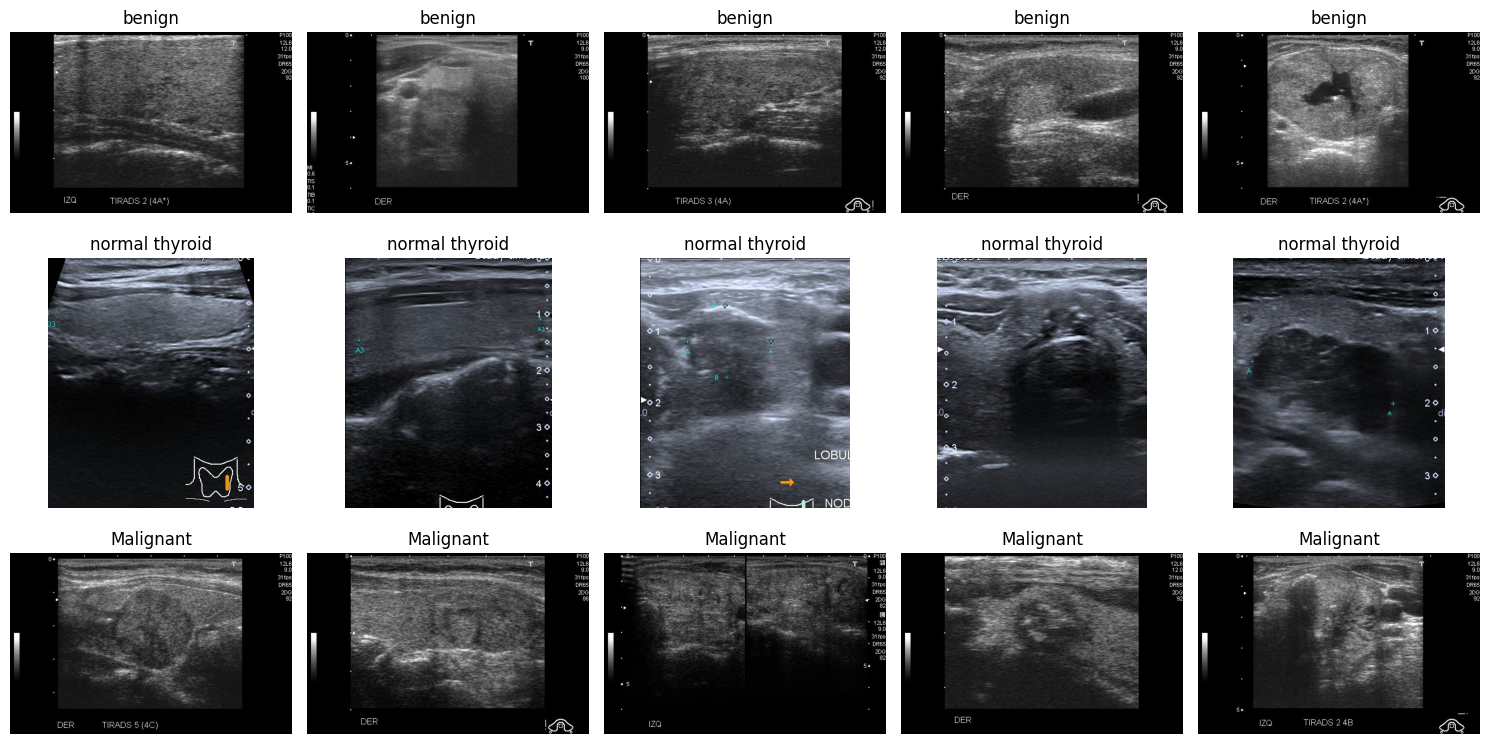

In [12]:
# 9. Visualize Random Images per Class
import matplotlib.pyplot as plt
import random
import cv2

def show_images_per_class(target_path, classes, n=5):
    plt.figure(figsize=(15, 8))
    for idx, cls in enumerate(classes):
        image_files = os.listdir(os.path.join(target_path, cls))
        for j in range(n):
            img_path = os.path.join(target_path, cls, random.choice(image_files))
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(classes), n, idx * n + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images_per_class(target_path, classes)


In [13]:
#4. Check Image Shapes and Formats

shapes = []
for cls in classes:
    cls_folder = os.path.join(target_path, cls)
    img_path = os.path.join(cls_folder, os.listdir(cls_folder)[0])
    with Image.open(img_path) as img:
        shapes.append(img.size)

print(f'Image sizes: {set(shapes)}')


Image sizes: {(560, 360), (415, 489)}


In [14]:
#5. Check for Corrupt or Empty Images
for cls in classes:
    cls_folder = os.path.join(target_path, cls)
    for img_name in os.listdir(cls_folder):
        try:
            img = Image.open(os.path.join(cls_folder, img_name))
            img.verify()
        except:
            print(f'Corrupt: {img_name} in {cls}')

In [15]:
#6. Detect and Log Corrupt Images

def find_corrupt_images(directory):
    corrupt_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    img.verify()  # Checks for image file integrity
            except (IOError, SyntaxError):
                corrupt_images.append(img_path)
    return corrupt_images

corrupt = find_corrupt_images('/kaggle/working/dataset-thyroid/dataset thyroid/train')
print(f"Found {len(corrupt)} corrupt images.")


Found 0 corrupt images.


In [16]:
# Step 7: Remove Corrupt/Empty Images

def remove_corrupt_images(directory):
    removed = 0
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                path = os.path.join(root, file)
                with Image.open(path) as img:
                    img.verify()
            except Exception as e:
                os.remove(path)
                removed += 1
    print(f"Removed {removed} corrupt images from {directory}")

remove_corrupt_images('/kaggle/working/thyroid-dataset/train')
remove_corrupt_images('/kaggle/input/dataset-thyroid/dataset thyroid/test')


Removed 0 corrupt images from /kaggle/working/thyroid-dataset/train
Removed 0 corrupt images from /kaggle/input/dataset-thyroid/dataset thyroid/test


In [17]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
# Step 8: Define transforms for training and validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [18]:
# Loaded full training dataset
full_dataset = datasets.ImageFolder(os.path.join(writable_base_path, "train"), transform=train_transforms)
# Spliting it into 90% testing and 10% validation
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [19]:
#Assigning the right transforms
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms
# Step 9: Create datasets and dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

test_dataset = datasets.ImageFolder(os.path.join(writable_base_path, "test"), transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Defining Efficient0 Model

In [20]:
# Determine the number of classes
num_classes = len(train_dataset.dataset.classes)  # Assuming train_dataset is a Subset

# Load the pre-trained EfficientNet-B0 model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Replace the final fully connected layer
model._fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model._fc.in_features, num_classes)
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 215MB/s]


Loaded pretrained weights for efficientnet-b0


In [21]:

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [22]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [23]:
import torch
import copy
import time

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

num_epochs = 20
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val':
            scheduler.step(epoch_loss)
            early_stopping(epoch_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered")
                model.load_state_dict(torch.load('best_model.pth'))
                break

    if early_stopping.early_stop:
        break

print(f'Best val Acc: {best_acc:.4f}')
model.load_state_dict(best_model_wts)

Epoch 1/20
----------
train Loss: 0.5455 Acc: 0.7440
val Loss: 0.4022 Acc: 0.8249
Epoch 2/20
----------
train Loss: 0.3326 Acc: 0.8568
val Loss: 0.2802 Acc: 0.8781
Epoch 3/20
----------
train Loss: 0.2064 Acc: 0.9152
val Loss: 0.2362 Acc: 0.9026
Epoch 4/20
----------
train Loss: 0.1415 Acc: 0.9405
val Loss: 0.2121 Acc: 0.9098
Epoch 5/20
----------
train Loss: 0.1095 Acc: 0.9557
val Loss: 0.2226 Acc: 0.9109
Epoch 6/20
----------
train Loss: 0.0845 Acc: 0.9641
val Loss: 0.2350 Acc: 0.9114
Epoch 7/20
----------
train Loss: 0.0754 Acc: 0.9680
val Loss: 0.2018 Acc: 0.9286
Epoch 8/20
----------
train Loss: 0.0674 Acc: 0.9699
val Loss: 0.1977 Acc: 0.9281
Epoch 9/20
----------
train Loss: 0.0602 Acc: 0.9728
val Loss: 0.2027 Acc: 0.9265
Epoch 10/20
----------
train Loss: 0.0582 Acc: 0.9742
val Loss: 0.2508 Acc: 0.9213
Epoch 11/20
----------
train Loss: 0.0571 Acc: 0.9743
val Loss: 0.2198 Acc: 0.9297
Epoch 12/20
----------
train Loss: 0.0479 Acc: 0.9768
val Loss: 0.3062 Acc: 0.9156
Epoch 13/20
-

<All keys matched successfully>

In [24]:
print(type(model))

<class 'efficientnet_pytorch.model.EfficientNet'>


In [25]:
from efficientnet_pytorch import EfficientNet

# Re-initialize model
model = EfficientNet.from_name('efficientnet-b0')
model._fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model._fc.in_features, num_classes)
)
model = model.to(device)

# Load correct weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [26]:
import torch
from torchmetrics.classification import (
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassConfusionMatrix
)
import pandas as pd

# Define number of classes and class names
num_classes = 3
class_names = ['Benign', 'Malignant', 'Normal']

# Initialize per-class metrics
precision = MulticlassPrecision(num_classes=num_classes, average=None).to(device)
recall = MulticlassRecall(num_classes=num_classes, average=None).to(device)
f1_score = MulticlassF1Score(num_classes=num_classes, average=None).to(device)
conf_matrix = MulticlassConfusionMatrix(num_classes=num_classes).to(device)

# Set model to evaluation mode
model.eval()
test_loss = 0.0
correct = 0

# Lists to collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        correct += torch.sum(preds == labels.data)

        all_preds.append(preds)
        all_labels.append(labels)

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Compute overall loss and accuracy
test_loss /= len(test_loader.dataset)
test_acc = correct.double() / len(test_loader.dataset)

# Compute per-class metrics
per_class_precision = precision(all_preds, all_labels)
per_class_recall = recall(all_preds, all_labels)
per_class_f1 = f1_score(all_preds, all_labels)
test_conf_matrix = conf_matrix(all_preds, all_labels)

# Print overall metrics
print(f'Test Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}\n')

# Print per-class metrics with class labels
for i in range(num_classes):
    print(f'Class {class_names[i]}:')
    print(f'  Precision: {per_class_precision[i]:.4f}')
    print(f'  Recall:    {per_class_recall[i]:.4f}')
    print(f'  F1 Score:  {per_class_f1[i]:.4f}\n')

# Convert confusion matrix to labeled DataFrame
conf_df = pd.DataFrame(
    test_conf_matrix.cpu().numpy(),
    index=[f'True {name}' for name in class_names],
    columns=[f'Pred {name}' for name in class_names]
)

print("Confusion Matrix:")
print(conf_df)


Test Loss: 0.0949 | Accuracy: 0.9666

Class Benign:
  Precision: 0.9375
  Recall:    1.0000
  F1 Score:  0.9677

Class Malignant:
  Precision: 0.9897
  Recall:    0.9829
  F1 Score:  0.9863

Class Normal:
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000

Confusion Matrix:
                Pred Benign  Pred Malignant  Pred Normal
True Benign              60               0            0
True Malignant            0             287            5
True Normal               4               3            0


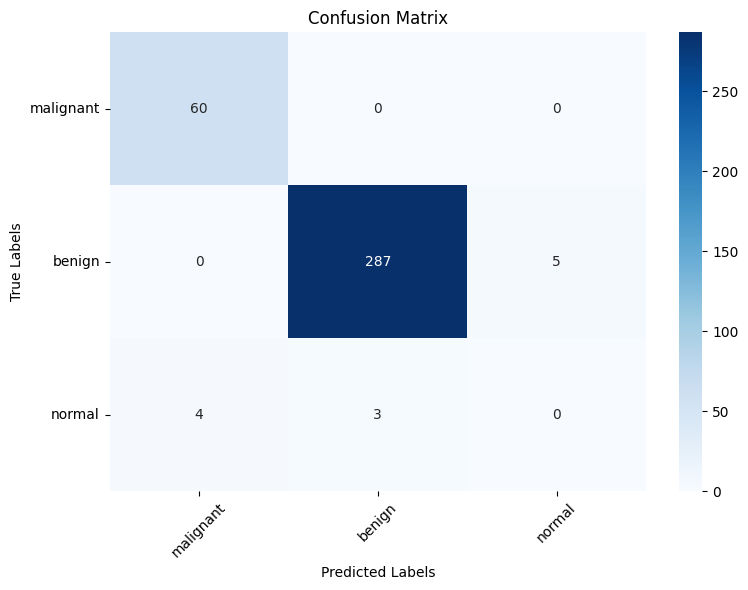

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define class names
class_names = ['malignant', 'benign', 'normal']

# Move to CPU and convert to numpy
conf_matrix_np = test_conf_matrix.cpu().numpy()

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_np, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [28]:
import torch
from torchmetrics.classification import (
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassConfusionMatrix
)

# Define number of classes
num_classes = 3

# Initialize metrics
precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
f1_score = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
conf_matrix = MulticlassConfusionMatrix(num_classes=num_classes).to(device)

# Set model to evaluation mode
model.eval()
test_loss = 0.0
correct = 0

# Lists to collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        correct += torch.sum(preds == labels.data)

        all_preds.append(preds)
        all_labels.append(labels)

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Compute metrics
test_loss /= len(test_loader.dataset)
test_acc = correct.double() / len(test_loader.dataset)

test_precision = precision(all_preds, all_labels)
test_recall = recall(all_preds, all_labels)
test_f1 = f1_score(all_preds, all_labels)
test_conf_matrix = conf_matrix(all_preds, all_labels)

# Print results
print(f'Test Loss: {test_loss:.4f} | Acc: {test_acc:.4f}')
print(f'Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1 Score: {test_f1:.4f}')
print(f'Confusion Matrix:\n{test_conf_matrix}')


Test Loss: 0.0949 | Acc: 0.9666
Precision: 0.6424 | Recall: 0.6610 | F1 Score: 0.6513
Confusion Matrix:
tensor([[ 60,   0,   0],
        [  0, 287,   5],
        [  4,   3,   0]], device='cuda:0')


In [29]:
import torch
from PIL import Image
from torchvision import transforms
from efficientnet_pytorch import EfficientNet

# Define class names in correct order
class_names = ['benign', 'malignant', 'normal']

# Define image preprocessing (must match training transforms)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet means
                         [0.229, 0.224, 0.225])  # ImageNet stds
])

# Load image
image_path = '/kaggle/working/thyroid-dataset/test/benign/2_10.jpg'  # replace with your image
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Load trained model
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(model._fc.in_features, num_classes)
)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model = model.to(device)
model.eval()

# Make prediction
with torch.no_grad():
    input_tensor = input_tensor.to(device)
    outputs = model(input_tensor)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    predicted_class = torch.argmax(probs, 1).item()
    confidence = probs[0, predicted_class].item()

# Print result
print(f'Predicted Class: {class_names[predicted_class]} (Confidence: {confidence:.2f})')

Loaded pretrained weights for efficientnet-b0
Predicted Class: benign (Confidence: 1.00)


In [30]:
from IPython.display import FileLink
FileLink('best_model.pth')

/kaggle/working/best_model.pth

# Resnet18

In [31]:
# Step 1: Define model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)  # 3 classes
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


In [32]:
# Step 6: Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 7: Train model
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/5: 100%|██████████| 540/540 [00:36<00:00, 14.82it/s]


Epoch 1, Loss: 0.6431


Epoch 2/5: 100%|██████████| 540/540 [00:36<00:00, 14.68it/s]


Epoch 2, Loss: 0.5798


Epoch 3/5: 100%|██████████| 540/540 [00:36<00:00, 14.63it/s]


Epoch 3, Loss: 0.5572


Epoch 4/5: 100%|██████████| 540/540 [00:36<00:00, 14.66it/s]


Epoch 4, Loss: 0.5377


Epoch 5/5: 100%|██████████| 540/540 [00:36<00:00, 14.82it/s]

Epoch 5, Loss: 0.5674


In [33]:
# Step 8: Evaluate model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 84.12%



Classification Report:
              precision    recall  f1-score   support

      benign       0.57      0.58      0.58        60
   malignant       0.90      0.91      0.91       292
      normal       0.00      0.00      0.00         7

    accuracy                           0.84       359
   macro avg       0.49      0.50      0.49       359
weighted avg       0.82      0.84      0.83       359



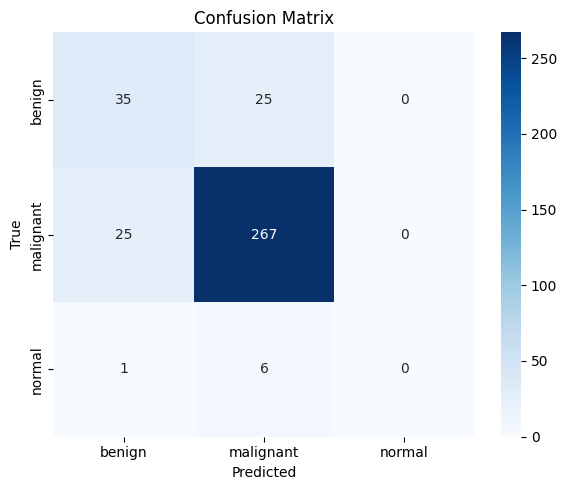

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Store true and predicted labels
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Class names from dataset
class_names = test_dataset.classes

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [35]:
import torch.nn.functional as F
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avgpool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SEResNet(nn.Module):
    def __init__(self, base_model, num_classes=3):
        super(SEResNet, self).__init__()
        self.base_model = base_model

        # Replace some layers with SE blocks
        self.base_model.layer1[0].se = SEBlock(64)
        self.base_model.layer2[0].se = SEBlock(128)
        self.base_model.layer3[0].se = SEBlock(256)
        self.base_model.layer4[0].se = SEBlock(512)

        self.base_model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        for layer in self.base_model.layer1:
            x = layer(x)
            if hasattr(layer, 'se'):
                x = layer.se(x)
        for layer in self.base_model.layer2:
            x = layer(x)
            if hasattr(layer, 'se'):
                x = layer.se(x)
        for layer in self.base_model.layer3:
            x = layer(x)
            if hasattr(layer, 'se'):
                x = layer.se(x)
        for layer in self.base_model.layer4:
            x = layer(x)
            if hasattr(layer, 'se'):
                x = layer.se(x)

        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.fc(x)
        return x

In [36]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(pretrained=True)
model = SEResNet(resnet, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = correct / total
    print(f"Epoch {epoch+1}: Loss = {running_loss:.4f}, Accuracy = {acc:.4f}")

# === Final Evaluation on Test Set ===
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nFinal Evaluation on Test Set:")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

# Call evaluation after last epoch
evaluate_model(model, test_loader, device)

Epoch 1: Loss = 283.3993, Accuracy = 0.7496
Epoch 2: Loss = 174.9892, Accuracy = 0.8584
Epoch 3: Loss = 99.8125, Accuracy = 0.9248
Epoch 4: Loss = 67.1096, Accuracy = 0.9494
Epoch 5: Loss = 49.1176, Accuracy = 0.9625
Epoch 6: Loss = 44.0126, Accuracy = 0.9653
Epoch 7: Loss = 36.5275, Accuracy = 0.9696
Epoch 8: Loss = 36.1590, Accuracy = 0.9698
Epoch 9: Loss = 33.0537, Accuracy = 0.9705
Epoch 10: Loss = 30.2253, Accuracy = 0.9717

Final Evaluation on Test Set:
Classification Report:
              precision    recall  f1-score   support

           0     0.9836    1.0000    0.9917        60
           1     0.9798    0.9966    0.9881       292
           2     1.0000    0.1429    0.2500         7

    accuracy                         0.9805       359
   macro avg     0.9878    0.7131    0.7433       359
weighted avg     0.9808    0.9805    0.9743       359

Confusion Matrix:
[[ 60   0   0]
 [  1 291   0]
 [  0   6   1]]
